In [1]:
import boto3
from sagemaker.model import Model
from datetime import datetime

In [2]:
model_name = 'object-detection-2020-05-05-14-38'
sm = boto3.client('sagemaker')

resp = sm.describe_model(ModelName=model_name)
resp

{'ModelName': 'object-detection-2020-05-05-14-38',
 'PrimaryContainer': {'Image': '433757028032.dkr.ecr.us-west-2.amazonaws.com/object-detection:latest',
  'Mode': 'SingleModel',
  'ModelDataUrl': 's3://beyoung-sagemaker/coco-object-detection-20200427/output/object-detection-2020-04-27-02-50-13-765/output/model.tar.gz'},
 'ExecutionRoleArn': 'arn:aws:iam::476271697919:role/service-role/AmazonSageMaker-ExecutionRole-20200427T094649',
 'CreationTime': datetime.datetime(2020, 5, 21, 14, 39, 43, 511000, tzinfo=tzlocal()),
 'ModelArn': 'arn:aws:sagemaker:us-west-2:476271697919:model/object-detection-2020-05-05-14-38',
 'EnableNetworkIsolation': False,
 'ResponseMetadata': {'RequestId': '5f05f109-927b-4528-89c9-43f60d5cdd40',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5f05f109-927b-4528-89c9-43f60d5cdd40',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '577',
   'date': 'Thu, 21 May 2020 15:50:15 GMT'},
  'RetryAttempts': 0}}

In [3]:
sm_model = Model(model_data = resp['PrimaryContainer']['ModelDataUrl'], image = resp['PrimaryContainer']['Image'], 
                 role = resp['ExecutionRoleArn'])

In [4]:
endpoint_name = datetime.now().strftime("object-detection-%Y-%m-%m-%H-%M")
sm_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium', endpoint_name=endpoint_name, wait=False)
endpoint_name

'object-detection-2020-05-05-15-50'

# SageMaker Predictor

In [5]:
from sagemaker.predictor import RealTimePredictor

In [6]:
object_detector = RealTimePredictor(endpoint=endpoint_name)

In [7]:
file_name = 'dog.jpg'
!wget -O {file_name} https://live.staticflickr.com/4106/5052728523_010830b44e_k_d.jpg

--2020-05-21 16:00:35--  https://live.staticflickr.com/4106/5052728523_010830b44e_k_d.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 13.224.9.167, 2600:9000:2164:3c00:0:5a51:64c9:c681, 2600:9000:2164:5200:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|13.224.9.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg                 [ <=>                ] 934.65K  --.-KB/s    in 0.05s   

2020-05-21 16:00:35 (16.7 MB/s) - ‘dog.jpg’ saved [957084]



In [8]:
with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)

In [9]:
import json

object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
print (detections)

{'prediction': [[0.0, 0.5193533897399902, 0.7318029999732971, 0.0, 0.8950926661491394, 0.5901554822921753], [0.0, 0.4086921811103821, 0.33753877878189087, 0.021686136722564697, 0.48797541856765747, 0.6339951157569885], [16.0, 0.3573471009731293, 0.12380659580230713, 0.4696325659751892, 0.319585382938385, 0.7207352519035339], [0.0, 0.19627106189727783, 0.35112032294273376, 0.03354862332344055, 0.4611310660839081, 0.3973284661769867], [0.0, 0.1931942105293274, 0.24369747936725616, 0.0803641751408577, 0.2819262742996216, 0.1748996376991272], [0.0, 0.1768728643655777, 0.24929901957511902, 0.051351457834243774, 0.43926677107810974, 0.621351957321167], [0.0, 0.17471356689929962, 0.34595683217048645, 0.07647348940372467, 0.3690265715122223, 0.16598279774188995], [0.0, 0.17429010570049286, 0.5162597298622131, 0.4574698805809021, 0.6257964968681335, 0.705842912197113], [0.0, 0.16948014497756958, 0.3762543797492981, 0.046750858426094055, 0.4526367783546448, 0.18383122980594635], [0.0, 0.15868170

In [10]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=1)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.savefig('result.jpg', dpi=500)
        plt.show()

In [11]:
object_categories = ['person', 'bicycle', 'car',  'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 
                     'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog',
                     'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
                     'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                     'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                     'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot',
                     'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable',
                     'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
                     'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
                     'toothbrush']


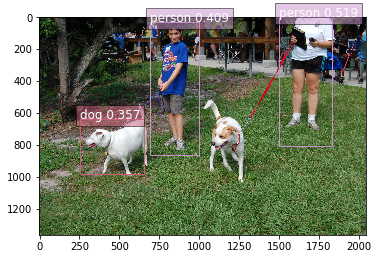

In [12]:
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.30
# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

# Delete endpoint

In [14]:
import sagemaker
sagemaker.Session().delete_endpoint(object_detector.endpoint)